<a href="https://colab.research.google.com/github/szut-thiel/LaundrySymbolAI/blob/master/LaundrySymbolAITraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### **Installing Modules on Notebook**
All used modules will be installed and imported

In [1]:
# installing modules for tensorflow
!pip install tensorflow==2.0 mnist pillow

# installing modules for computer vision
!pip install svglib
!pip install reportlab


import tensorflow as tf
import numpy as np  # used to prepare data for tensorflow
import matplotlib.pyplot as plt  # used to plot images for debugging
import mnist  # TODO: remove after substitution of mnist Sequence class

import os  # used for actions on filesystem 
import random  # used for splitting trainings set
import math  # used for splitting trainings set

# computer vision
from pathlib import Path
from PIL import Image
import shutil
import errno
import cv2
import numpy
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPM

# restarting runtime
# os.kill(os.getpid(), 9)

### **Preparing Trainings Data**


In [2]:
# Before launching the preparation of trainings data, a zipped directory named
# raw_images_lite.zip including the directory raw_images_lite with inner
# directories of all categories with images and license file has to uploaded to
# the github repository.

# updating set of images by deleting old set, downloading and unzipping new set
!rm -rf raw_images_lite training_lite
!wget https://raw.github.com/szut-thiel/LaundrySymbolAI/master/raw_images_lite.zip 
!unzip -q raw_images_lite.zip
!rm -rf raw_images_lite.zip training.zip


SOURCE = "raw_images_lite"
TRAINING_IMAGES = "training_lite"
IMAGE_WIDTH = 32
NUMBER_OF_ORIENTATIONS = 72

# preparing trainings data
def prepare_training(source, target):
  # if trainings data already exist, remove them before calculating new one
  if os.path.exists(target):
    shutil.rmtree(target)

  # copying downloaded raw images to the new training directory
  try:
    shutil.copytree(source, target)
  except OSError as error:
    if error.errno == errno.ENOTDIR:
      shutil.copy(source, target)
    else:
      raise

  # preparing all raw images for trainging
  for path, directories, files in os.walk(target):
    for directory in directories:
      prepare_category(path, directory)


# preparing all images of one category
def prepare_category(path, category):
  index = 0
  for path, directories, files in os.walk(os.path.join(path, category)):
    for file in files:
      prepare_image(os.path.join(path, file), category, index)
      index += 1


# preparing one image
def prepare_image(path, category, index):
  try:
    png_path = path

    # converting svg images to png images
    if path.endswith(".svg"):
      png_path = "{}png".format(path[:-3])
      svg = svg2rlg(path)
      renderPM.drawToFile(svg, png_path, fmt="PNG")
      os.remove(path)

    # loading png image
    image = load_image(png_path)
    
    # converting image to grayscale image
    image = grayscale_image(image)

    # extending image to square
    image = square_image(image)

    # scaling image
    image = scale_image(image, IMAGE_WIDTH, IMAGE_WIDTH)

    # rotating image
    for angle in range(0, 360, 360 // NUMBER_OF_ORIENTATIONS):
      # thresholded_image = threshold_image(image) # FIXME: remove?
      rotated_image = rotate_image(image, angle)

      prepared_path = os.path.join(os.path.dirname(path),
                                   "{}.{}.a{:03d}.png".format(category, index, angle))

      # prepared_path = "{}.a{:03d}.png".format(path[:-4], angle)
      save_image(rotated_image, prepared_path)
    
    # deleting raw image
    os.remove(png_path)

  except ValueError as error:
    print(error)


# convert rgb images to grayscale images
def grayscale_image(image):
  return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


# extending images to squared resolution
def square_image(image):
  w = max(image.shape[0], image.shape[1])
  y = (w - image.shape[0]) // 2
  x = (w - image.shape[1]) // 2
  return cv2.copyMakeBorder(image, y, y, x, x, cv2.BORDER_CONSTANT,
                            value=[255, 255, 255])


# scaling image
def scale_image(image, width, height):
  return cv2.resize(image, (width, height), interpolation=cv2.INTER_AREA)


# rotating image around center
def rotate_image(image, angle):
  image_center = tuple(numpy.array(image.shape[1::-1]) / 2)
  rotation_matrix = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  return cv2.warpAffine(image, rotation_matrix, image.shape[1::-1],
                        flags=cv2.INTER_LINEAR, borderValue=(255, 255, 255))
  

# converting image to black and white image
def threshold_image(image, threshold=0.5):
  _, threshed = cv2.threshold(image, int(255 * threshold), 255, cv2.THRESH_BINARY)
  return threshed


# inverting image
def invert_image(image):
  return cv2.bitwise_not(image)


# loading image from file
def load_image(path):
  return cv2.imread(path, cv2.IMREAD_UNCHANGED)


# saving image to file
def save_image(image, path):
  cv2.imwrite(path, image)


prepare_training(SOURCE, TRAINING_IMAGES)


--2020-01-16 14:43:06--  https://raw.github.com/szut-thiel/LaundrySymbolAI/master/raw_images_lite.zip
Resolving raw.github.com (raw.github.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.github.com (raw.github.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/szut-thiel/LaundrySymbolAI/master/raw_images_lite.zip [following]
--2020-01-16 14:43:06--  https://raw.githubusercontent.com/szut-thiel/LaundrySymbolAI/master/raw_images_lite.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95500 (93K) [application/zip]
Saving to: ‘raw_images_lite.zip’

raw_images_lite.zip 100%[===================>]  93.26K  --.-KB/s    in 0.02s   

2020-01-16 14:43:

### **Loading Training Set to Numpy-Array FIXME: substitute by preparation pipeline: opencv and numpy at once**


In [0]:
TRAINING_PERCENTAGE = 0.7 # between 0 and 1


# loading image data of file and returning numpy array
def load_image_data(path):
  image = Image.open(path)
  return np.array(image.getdata()).reshape(image.size[1], image.size[0], 1) # FIXME


def load_image_data_of_category(path, category):
  image_data_of_category = []
  for path, directories, files in os.walk(os.path.join(path, category)):
    for file in files:
      image_data = load_image_data(os.path.join(path, file))
      image_data_of_category.append(image_data)
  return image_data_of_category


def load_training_data(path):
  categories = []
  training_image_data = []
  training_label = []
  testing_image_data = []
  testing_label = []

  for path, directories, files in os.walk(path):
    for category in directories:
      if category not in categories:
        categories.append(category)

      image_data = load_image_data_of_category(path, category)
      label = [categories.index(category)] * len(image_data)

      # shuffling lists
      zipped_list = list(zip(image_data, label))
      random.shuffle(zipped_list)
      (image_data, label) = zip(*zipped_list)
      image_data = list(image_data)
      label = list(label)

      # splitting shuffled tuples and adding them to lists
      split_index = math.floor(len(image_data) * TRAINING_PERCENTAGE)

      training_image_data += image_data[:split_index]
      training_label += label[:split_index]

      testing_image_data += image_data[split_index:]      
      testing_label += label[split_index:]

  return (categories,
          training_image_data, training_label,
          testing_image_data, testing_label)
  

(categories,
 training_image_data, training_label,
 testing_image_data, testing_label) = load_training_data(TRAINING_IMAGES)



check: bleaching_dont


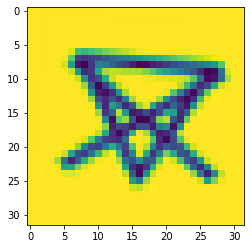

In [5]:
check_index = random.randint(0, len(training_image_data) - 1)
print("check: {}".format(categories[training_label[check_index]]))
image = np.resize(training_image_data[check_index], (32, 32))
_ = plt.imshow(image)

*italicized text*### **import dataset**

In [6]:
from tensorflow.keras import layers

model = tf.keras.Sequential()

kernel_size = 8  # was 4

model.add(layers.Input(shape=(32, 32, 1)))
model.add(layers.Conv2D(6, (kernel_size, kernel_size), activation=tf.nn.relu))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(9, (kernel_size, kernel_size), activation=tf.nn.relu))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(12, (kernel_size, kernel_size), activation=tf.nn.relu))
model.add(layers.MaxPooling2D((2, 2), (2, 2)))
model.add(layers.Dense(20, activation=tf.nn.relu))
model.add(layers.Flatten())
model.add(layers.Dense(58, activation=tf.nn.softmax))

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["mae", "accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 25, 25, 6)         390       
_________________________________________________________________
dropout (Dropout)            (None, 25, 25, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 18, 9)         3465      
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 18, 9)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 12)        6924      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 5, 12)          0         
_________________________________________________________________
dense (Dense)                (None, 5, 5, 20)          2

### **Training**

In [14]:
# np.expand_dims(training_image_data, 0)
# np.expand_dims(1000, testing_image_data, -1)

BATCH_SIZE = 10000

print(asnparray(training_image_data.shape)

training_image_data = model.predict(np.expand_dims(training_image_data, axis=0), batch_size=BATCH_SIZE)
testing_image_data = model.predict(np.expand_dims(testing_image_data, axis=0), batch_size=BATCH_SIZE)

history = model.fit(training_image_data, training_label,
                    epochs=100,
                    batch_size=BATCH_SIZE, 
                    validation_data=(testing_image_data, testing_label))

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'g.', label="Training Loss")
plt.plot(epochs, val_loss, "b", label="Validation Loss")
plt.title("Training Evaluation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

AttributeError: ignored

### **Testing**

Guess: 28: bleaching_dont
Actually: washing_30_very_gentle


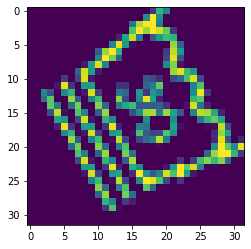

In [0]:
predictions = model.predict(tf.cast(test_images, tf.float32))

image_id = random.randint(0, len(predictions))
guess = test_labels[np.argmax(predictions[image_id])]
print("Guess: " + str(guess) + ": " + categories[guess])

print("Actually: " + categories[test_labels[image_id]])

# the "_ = " prevents the object details to be printed out
_ = plt.imshow(test_images[image_id].reshape(32, 32))


### **Saving and exporting to TF Lite file**

In [0]:
tf.saved_model.save(model, ".")

converter = tf.lite.TFLiteConverter.from_saved_model(".")
tflite_model = converter.convert()
open("./assets/laundrysymbol_ai_model.tflite", "wb").write(tflite_model)

!rm saved_model.pb

INFO:tensorflow:Assets written to: ./assets
